In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import networkx as nx

from collections import Counter

N = 35

G = 2

In [2]:
lambda_a = G + (N % 3)
lambda_b = G + (N % 5)
N_a = 2 + (G % 2)
N_b = 1 + (N % 2)
R_a = 1 + (G % 2)
R_b = 2 - (G % 2)

print('Лямбда А =',lambda_a)
print('Лямбда Б =',lambda_b)
print('Na =',N_a)
print('Nb =',N_b)
print('Ra =',R_a)
print('Rb =',R_b)

Лямбда А = 4
Лямбда Б = 2
Na = 2
Nb = 2
Ra = 1
Rb = 2


Система состоит из двух последовательно соединенных частей - A и B. Рассмотрим и пронумеруем возможные состояния частей.

In [3]:
states = []
for a in range(N_a + R_a + 1):  # 0 до 3
    for b in range(1,N_b + R_b + 1):  # 1 до 4, случай с 0 не рассматриваем т.к. при b=1 система перестает работать
        states.append((a, b))

print("Possible States:")
for i, state in enumerate(states):
    print(f"State {i}: {state}")

Possible States:
State 0: (0, 1)
State 1: (0, 2)
State 2: (0, 3)
State 3: (0, 4)
State 4: (1, 1)
State 5: (1, 2)
State 6: (1, 3)
State 7: (1, 4)
State 8: (2, 1)
State 9: (2, 2)
State 10: (2, 3)
State 11: (2, 4)
State 12: (3, 1)
State 13: (3, 2)
State 14: (3, 3)
State 15: (3, 4)


In [4]:
def state_to_number(a, b):
    """
    Преобразует параметры (a, b) в номер состояния.
    
    :param a: Первая координата состояния.
    :param b: Вторая координата состояния.
    :return: Номер состояния от 0 до 15.
    """
    if not (0 <= a <= 3) or not (1 <= b <= 4):
        raise ValueError("Параметры 'a' должны быть в пределах [0, 3], а 'b' — в [1, 4].")
    
    return a * 4 + (b - 1)

def number_to_state(state_number):
    """
    Преобразует номер состояния в параметры (a, b).
    
    :param state_number: Номер состояния от 0 до 15.
    :return: Кортеж (a, b).
    """
    if not (0 <= state_number <= 15):
        raise ValueError("Номер состояния должен быть в диапазоне от 0 до 15.")
    
    a = state_number // 4
    b = (state_number % 4) + 1
    return a, b

Матрица интенсивностей переходов. Имеет размерность 16 на 16. Индекс текущего состояния =  a * B_states + b; Проходим по каждому состоянию и указываем для него вероятности перехода в соседние состояния при отказе Б как интенсивность Б, и при отказе А как интенсивность А


In [5]:
def create_intensity_matrix(lambda_a, lambda_b):
    """
    Создает матрицу интенсивностей переходов для 16 состояний.
    
    :param lambda_a: Интенсивность перехода для уменьшения a на 1.
    :param lambda_b: Интенсивность перехода для уменьшения b на 1.
    :return: Матрица интенсивностей переходов размером 16x16.
    """
    size = 16
    Q = np.zeros((size, size))  # Инициализация матрицы нулями
    
    for a in range(4):  # a может быть 0, 1, 2 или 3
        for b in range(1, 5):  # b может быть 1, 2, 3 или 4
            current_state = state_to_number(a, b)
            transition_sum = 0 
            
            # Если a = 0 или b = 1, пропускаем
            if a == 0 or b == 1:
                continue
            
            # Переход из (a, b) в (a-1, b)
            if a > 0:
                next_state_a = state_to_number(a - 1, b)
                Q[current_state, next_state_a] = lambda_a
                transition_sum += lambda_a
            
            # Переход из (a, b) в (a, b-1)
            if b > 1:
                next_state_b = state_to_number(a, b - 1)
                Q[current_state, next_state_b] = lambda_b
                transition_sum += lambda_b
            
            Q[current_state, current_state] = -transition_sum

    return Q

Q = create_intensity_matrix(lambda_a,lambda_b)

width = 5 
for row in Q:
    print(" | ".join(f"{value:>{width}.2f}" for value in row))

 0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  4.00 |  0.00 |  0.00 |  2.00 | -6.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  4.00 |  0.00 |  0.00 |  2.00 | -6.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  4.00 |  0.00 |  0.00 |  2.00 | -6.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 

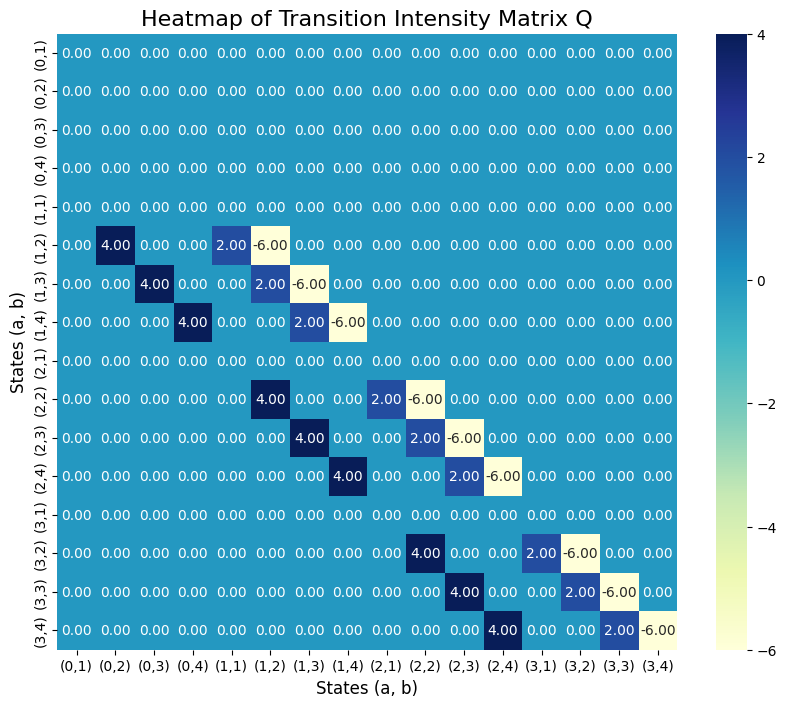

In [6]:
# Создание меток для осей
states = [f'({a},{b})' for a in range(4) for b in range(1, 5)]

# Настройка heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(Q, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=states, yticklabels=states)
plt.title('Heatmap of Transition Intensity Matrix Q', fontsize=16)
plt.xlabel('States (a, b)', fontsize=12)
plt.ylabel('States (a, b)', fontsize=12)
plt.show()

3.	записать дифференциальные уравнения Колмогорова;
4.	методами численного интегрирования решить полученную систему дифференциальных уравнений, исходя из того, что в начальный момент времени все устройства исправны

Мы можем записать систему дифференциальных уравнений Колмогорова, которая описывает вероятность нахождения системы в каждой из состояний во времени. Используем метод численного интегрирования для решения этих уравнений.


In [7]:

def kolmogorov_equations(t, p, Q):
    # Создаем массив для производных
    dpdt = np.zeros_like(p)
    
    # Заполняем производные по уравнениям Колмогорова
    for i in range(len(p)):
        dpdt[i] = np.sum(Q[:, i] * p)  # Суммируем по всем состояниям

    return dpdt

def get_solution():
    # Начальные вероятности
    initial_state = np.zeros(16) # Вектор начального состояния, инициализируем нулями
    initial_state[15] = 1 #Начальное состояние (3,4)

    # Время интеграции
    t_span = (0, 2)  #От 0 до 2
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # 100 точек во времени

    # Решение системы уравнений
    solution = solve_ivp(kolmogorov_equations, t_span, initial_state, args=(Q,), t_eval=t_eval)

    # Выводим результаты
    print("Временные точки:", solution.t)
    print("Вероятности:\n", solution.y)
    return solution


solution = get_solution()

# Выводим результаты
print("Временные точки:", solution.t)
print("Вероятности:\n", solution.y)

Временные точки: [0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181818 0.2020202  0.22222222
 0.24242424 0.26262626 0.28282828 0.3030303  0.32323232 0.34343434
 0.36363636 0.38383838 0.4040404  0.42424242 0.44444444 0.46464646
 0.48484848 0.50505051 0.52525253 0.54545455 0.56565657 0.58585859
 0.60606061 0.62626263 0.64646465 0.66666667 0.68686869 0.70707071
 0.72727273 0.74747475 0.76767677 0.78787879 0.80808081 0.82828283
 0.84848485 0.86868687 0.88888889 0.90909091 0.92929293 0.94949495
 0.96969697 0.98989899 1.01010101 1.03030303 1.05050505 1.07070707
 1.09090909 1.11111111 1.13131313 1.15151515 1.17171717 1.19191919
 1.21212121 1.23232323 1.25252525 1.27272727 1.29292929 1.31313131
 1.33333333 1.35353535 1.37373737 1.39393939 1.41414141 1.43434343
 1.45454545 1.47474747 1.49494949 1.51515152 1.53535354 1.55555556
 1.57575758 1.5959596  1.61616162 1.63636364 1.65656566 1.67676768
 1.6969697  1.71717172 1.73737374 1.75757576 1

Строим график вероятностей

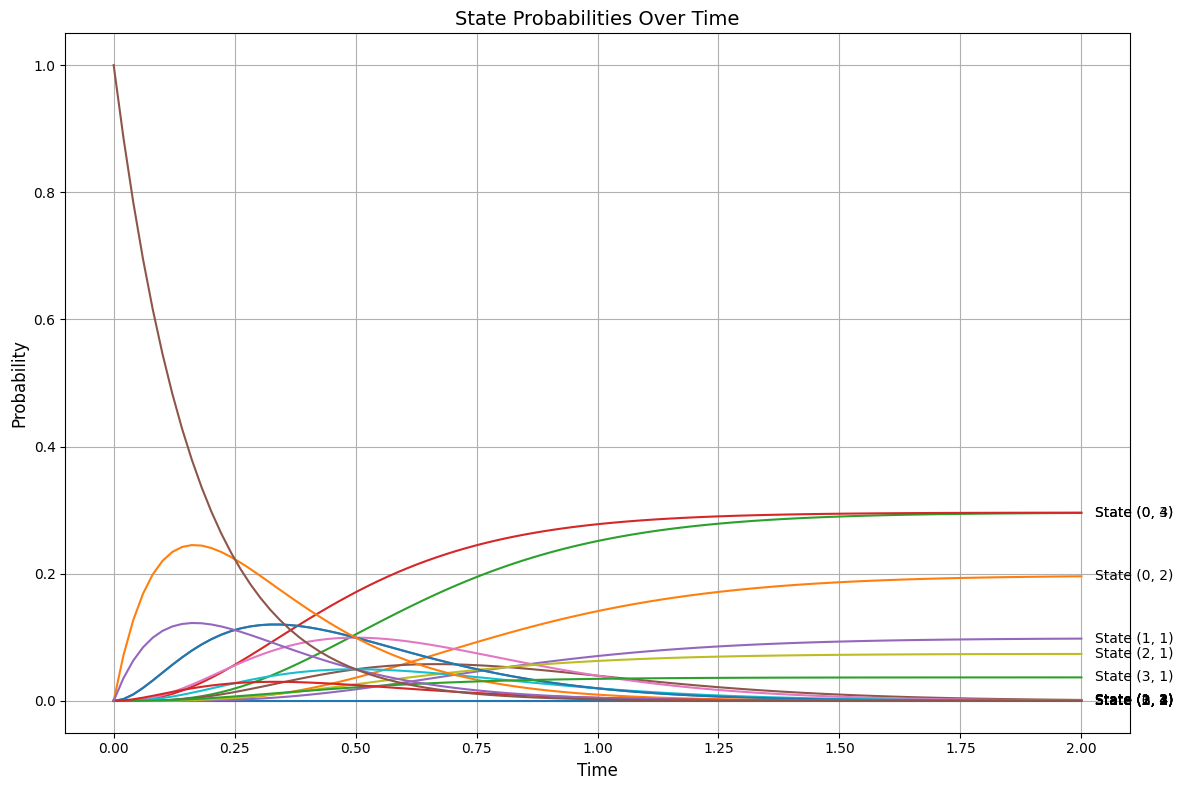

In [8]:
import matplotlib.pyplot as plt

# Установка размера графика
plt.figure(figsize=(12, 8))  # Увеличиваем размер графика

# Построение графиков вероятности
for i in range(16):
    plt.plot(solution.t, solution.y[i], label=f'State {number_to_state(i)}')  # Используем формат (a, b)
    
    # Добавление метки рядом с линией
    final_time = solution.t[-1]  # Берем последнее время для аннотации
    final_prob = solution.y[i][-1]  # Вероятность в конце
    
    # Перемещение аннотаций вправо
    plt.annotate(
        f'State {number_to_state(i)}', 
        xy=(final_time, final_prob), 
        xytext=(10, 0),  # Смещение метки вправо
        textcoords='offset points',
        fontsize=10,  # Размер шрифта
        verticalalignment='center',  # Выравнивание по центру по вертикали
        ha='left'  # Выравнивание текста по левой стороне
    )

# Заголовок и подписываем оси
plt.title('State Probabilities Over Time', fontsize=14)  # Заголовок графика
plt.xlabel('Time', fontsize=12)  # Подпись оси X
plt.ylabel('Probability', fontsize=12)  # Подпись оси Y

# Настроим отображение для лучшего визуального эффекта
plt.tight_layout()  # Автоматическая подстройка размеров для лучшего отображения
plt.grid(True)  # Добавляем сетку для лучшей читаемости графика
plt.show()  # Отображаем график


Построение графика функции надежности системы

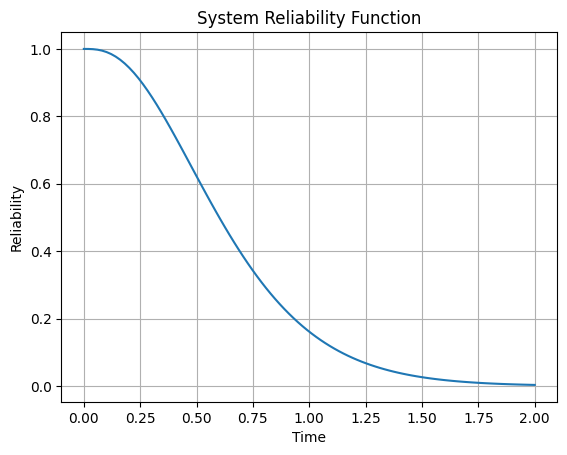

In [9]:
# Функция, определяющая надежность системы
def reliability_function(solution_y):
    total_reliability = 0  # Начальное значение надежности
    for i in range(16):
        a, b = number_to_state(i)  # Преобразуем индекс состояния в количества A и B
        if a >= 1 and b >= N_b:  # Проверяем условия надежности (по крайней мере одно A и NB B)
            total_reliability += solution_y[i]  # Суммируем вероятности состояния
            
    return total_reliability  # Возвращаем общую надежность

# Рассчитываем функцию надежности во времени
# Извлекаем вероятности из решения
reliability = [reliability_function(solution.y[:, j]) for j in range(solution.y.shape[1])]

# Построение графика надежности
plt.plot(solution.t, reliability)  # Рисуем график
plt.title('System Reliability Function')  # Заголовок
plt.xlabel('Time')  # Подпись оси X
plt.ylabel('Reliability')  # Подпись оси Y
plt.grid()  # Добавляем сетку для лучшей читаемости
plt.show()  # Отображаем график


Получаем мат ожидание времени безотказной работы интегрированием функции отказов

In [10]:

expected_uptime = np.trapezoid(reliability,solution.t)

print(f"Ожидаемое время безотказной работы: {expected_uptime:.2f} единиц времени")

Ожидаемое время безотказной работы: 0.66 единиц времени


Иммитационное моделирование

In [11]:
def simulate():
    cur_state = 15
    a,b = number_to_state (cur_state)
    cur_time = 0

    while a > 0 and b >= 1:
        # Проверяем, что интенсивность выхода из текущего состояния отрицательная
        if Q[cur_state, cur_state] >= 0:
            break  # Если интенсивность не подходит, выходим из цикла

        # Вычисляем время простоя до следующего события
        idle_time = np.random.exponential(-1 / Q[cur_state, cur_state])
        cur_time += idle_time
        
        # Выбор следующего состояния
        # Создаем список возможных переходов и их вероятностей
        transition_probs = Q[cur_state] / -Q[cur_state, cur_state]  # Вероятности переходов
        transition_probs = np.clip(transition_probs, 0, None)  # Убираем отрицательные значения
        transition_probs /= transition_probs.sum()  # Нормализуем
        
        # Выбор следующего состояния с помощью распределения вероятностей
        next_state = np.random.choice(np.arange(Q.shape[0]), p=transition_probs)
        
        # Обновление текущего состояния
        cur_state = next_state
        a, b = number_to_state(cur_state)  # Переопределяем a и b для нового состояния
        print(cur_state)

    return cur_time


results = [simulate() for _ in range(100)]

# Статистический анализ
mean_time = np.mean(results)
std_dev_time = np.std(results)

# Вывод времени безотказной работы системы
print(f"Среднее время безотказной работы: {mean_time:.2f}")
print(f"Стандартное отклонение: {std_dev_time:.2f}")

14
13
9
8
14
13
12
11
7
6
2
14
10
6
2
14
10
6
5
1
14
10
6
2
11
7
3
14
10
6
5
4
11
10
9
5
4
11
7
3
14
13
12
14
13
9
5
1
14
13
9
8
14
10
6
5
1
11
7
3
14
13
9
5
1
11
7
3
14
10
6
5
1
14
10
9
8
11
7
6
5
4
11
7
3
14
10
6
5
1
11
7
3
14
13
12
14
10
6
2
11
7
6
5
4
14
13
9
5
4
11
7
3
14
10
6
2
11
7
3
14
13
12
14
10
6
2
11
10
6
2
11
7
6
2
11
10
9
5
1
14
10
9
5
4
11
7
3
11
7
3
11
7
3
11
7
3
14
10
6
2
11
7
6
2
14
10
6
5
1
14
10
9
5
1
11
7
3
14
10
6
2
11
7
3
11
10
6
5
1
14
10
6
2
14
10
6
2
11
10
6
2
11
7
3
14
10
6
2
11
7
3
11
10
6
5
4
11
7
6
2
14
10
6
2
11
10
6
5
1
14
13
12
14
10
9
8
11
7
6
2
11
7
3
14
13
12
14
10
9
5
1
11
7
3
14
13
9
5
1
11
7
3
11
7
3
14
10
6
5
1
14
13
12
11
7
3
14
13
9
5
1
11
7
3
11
7
6
5
1
11
7
6
5
1
11
10
6
2
11
10
6
5
1
14
10
6
2
11
10
6
5
1
14
13
9
5
4
11
10
6
5
1
11
7
3
11
7
3
14
13
12
11
7
3
11
10
9
8
11
7
3
14
10
6
2
11
7
3
14
10
9
8
14
10
6
5
4
11
7
3
14
10
9
5
1
11
7
6
2
14
13
12
11
10
6
2
14
13
9
5
1
11
7
3
11
7
6
5
4
11
10
9
5
4
Среднее время безотказной работы: 0.68
Ст

In [12]:
def simulate():
# Начальные состояния
    working_A = N_a  # Работающие устройства A
    working_B = N_b  # Работающие устройства B
    total_time = 0   # Общее время безотказной работы системы
    
    # Времена отказов для работающих устройств
    fail_times_A = [np.random.exponential(1 / lambda_a) for _ in range(N_a)]
    fail_times_B = [np.random.exponential(1 / lambda_b) for _ in range(N_b)]

    # События времени отказа для A и B
    events = [(fail_time, 'A') for fail_time in fail_times_A] + \
             [(fail_time, 'B') for fail_time in fail_times_B]

    # Сортируем события по времени
    events.sort()

    # Счетчик резервных устройств
    reserve_A = R_a  # Число запасных устройств A
    reserve_B = R_b  # Число запасных устройств B

    print(working_A,working_B,reserve_A,reserve_B)  
    print (events)

    
    while events:
        
        # Получаем следующее событие
        next_event_time, device_type = events.pop(0)
        
        # Увеличиваем общее время работы системы
        total_time = next_event_time

        # Обновляем состояние системы
        if device_type == 'A':
            # Одно устройство A отказало
            if reserve_A > 0:
                reserve_A -= 1  # Используем одно резервное A
                new_fail_time_A = total_time + np.random.exponential(1 / lambda_a)
                events.append((new_fail_time_A, 'A'))  # Добавляем новое время отказа для резервного A
                events.sort()
            else:
                working_A -= 1
        elif device_type == 'B':
            # Одно устройство B отказало
            if reserve_B > 0:
                reserve_B -= 1  # Используем одно резервное B
                new_fail_time_B = total_time + np.random.exponential(1 / lambda_b)
                events.append((new_fail_time_B, 'B'))  # Добавляем новое время отказа для резервного B
                events.sort()
            else:
                working_A -= 1

        # Проверяем, достаточно ли работающих устройств B
        if working_B < N_b or working_A < 1:
            break  # Система выходит из строя, если недостаточно B
        
        print(working_A,working_B,reserve_A,reserve_B)
        print (events)


    return total_time

# Проведение 100 симуляций
results = [simulate() for _ in range(100)]

# Статистический анализ
mean_time = np.mean(results)
std_dev_time = np.std(results)

# Вывод времени безотказной работы системы
print(f"Среднее время безотказной работы: {mean_time:.2f}")
print(f"Стандартное отклонение: {std_dev_time:.2f}")

2 2 1 2
[(0.12314378743034432, 'A'), (0.17475970273374608, 'A'), (0.34642475798836947, 'B'), (1.2439340952594162, 'B')]
2 2 0 2
[(0.1353095827733476, 'A'), (0.17475970273374608, 'A'), (0.34642475798836947, 'B'), (1.2439340952594162, 'B')]
1 2 0 2
[(0.17475970273374608, 'A'), (0.34642475798836947, 'B'), (1.2439340952594162, 'B')]
2 2 1 2
[(0.20245529158357384, 'A'), (0.2968349540617413, 'B'), (0.48408245312567355, 'A'), (0.6386733115539657, 'B')]
2 2 0 2
[(0.2968349540617413, 'B'), (0.48408245312567355, 'A'), (0.5202587278828539, 'A'), (0.6386733115539657, 'B')]
2 2 0 1
[(0.48408245312567355, 'A'), (0.5202587278828539, 'A'), (0.6386733115539657, 'B'), (1.5921480894834423, 'B')]
1 2 0 1
[(0.5202587278828539, 'A'), (0.6386733115539657, 'B'), (1.5921480894834423, 'B')]
2 2 1 2
[(0.1022280294385886, 'A'), (0.3118487440331452, 'A'), (0.6605054279776468, 'B'), (1.2024240736833511, 'B')]
2 2 0 2
[(0.22433458529193706, 'A'), (0.3118487440331452, 'A'), (0.6605054279776468, 'B'), (1.2024240736833